# 2D to 3D

In [5]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import mpl_toolkits.mplot3d as plt3d
import itertools

In [6]:
def create_points():
    points_map = {}
    points_list = list(itertools.permutations([-0.5,-0.5,-0.5,0,0,0,0.5,0.5,0.5], 3))
    new_points_list = []
    for each in points_list:
        if each in points_map:
            continue
        else:
            points_map[each] = 1
            new_points_list.append([each[0], each[1], each[2]]) 
    return np.array(new_points_list)

In [7]:
def preset_cams():
    r = 5
    focal_length = 0.06
    width = 256
    height = 256
    alpha = np.pi/6
    beta = np.pi/6
    
    cam1 = { 'position': [r * np.cos(beta) * np.cos(alpha), r * np.cos(beta) * np.sin(alpha), r * np.sin(beta)],
           'target':[0,0,0],
           'up':[0,0,1],
           'focal_length':focal_length,
           'film_width':0.035,
           'film_height':0.035,
           'width':width,
           'height':height,
           }
    
    alpha = np.pi/3
    beta = np.pi/6
    
    cam2 = { 'position': [r * np.cos(beta) * np.cos(alpha), r * np.cos(beta) * np.sin(alpha), r * np.sin(beta)],
           'target':[0,0,0],
           'up':[0,0,1],
           'focal_length':focal_length,
           'film_width':0.035,
           'film_height':0.035,
           'width':width,
           'height':height,
           }
    
    return cam1, cam2

In [8]:
def camera_coordinate_system(cam):
    zcam = np.array(cam['target']) - np.array(cam['position'])
    xcam = np.cross(zcam, cam['up'])
    ycam = np.cross(zcam, xcam)
    
    zcam = zcam / np.linalg.norm(zcam)
    xcam = xcam / np.linalg.norm(xcam)
    ycam = ycam / np.linalg.norm(ycam)
    
    origin = cam['position']
    return xcam, ycam, zcam, origin

In [9]:
cam1, cam2 = preset_cams()

In [10]:
#This is the transformation between the world and camera coordinates 
def extrinsics_matrix(cam):
    xcam, ycam, zcam, origin = camera_coordinate_system(cam)
    R = np.array([xcam[:], ycam[:], zcam[:]])
    t = np.dot(R, origin)
    M = np.append(R.T, [np.round(-t, 2)], axis = 0)
    return M

In [11]:
#This is the calibration matrix which describes the camera cordinates to the pixel space
def intrinsics_matrix(cam):
    x_0 = (cam['width']+1) * 0.5
    y_0 = (cam['height']+1) * 0.5
    f_x = cam['focal_length'] * cam['width'] / cam['film_width']
    f_y = cam['focal_length'] * cam['height'] / cam['film_height']
    K = [[f_x, 0, x_0] ,[0, f_y, y_0] , [0, 0, 1]]
    return np.array(K).T

In [12]:
#This is the camera matrix
def camera_matrix(cam):
    M = extrinsics_matrix(cam)
    K = intrinsics_matrix(cam)
    P = np.dot(M, K)
    return P
    

In [13]:
#Converting the points from 3D to 2D
def world2image(cam, points):
    P = camera_matrix(cam)
    points = np.reshape(points, (27, 3))
    pt = np.append(points, np.ones((27, 1)), axis=1)
    pt = np.dot(pt, P)
    x = pt[:, 0] / pt[:, 2]
    y = pt[:, 1] / pt[:, 2]
    points2d = []
    for i in range(0, len(x)):
        points2d.append([x[i], y[i]])
    return points2d, x, y

In [15]:
def color_list():
    color_list = ['Red', 'Red', 'Red', 'Green', 'Green', 'Green', 'Blue', 'Blue', 'Blue', 'Orange', 'Orange', 'Orange', 'Yellow', 'Yellow', 'Yellow', 'Purple', 'Purple', 'Purple', 'Pink', 'Pink', 'Pink', 'Black', 'Black', 'Black', 'Brown', 'Brown', 'Brown']
    return color_list

In [16]:
def triangulate(points1, points2, P1, P2):
    points3d = np.zeros((27, 3))
    for i in range(0, 27):
        points3d[i] = triangulate_one_point(np.array(points1[i]).T, np.array(points2[i]).T, np.array(P1).T, np.array(P2).T)
    return points3d

In [17]:
# Here I am using the SVD (singular value decomposition) trick which is mentioned in the notes.
# Finding the x that minimizes ||Ax|| subject to ||x|| = 1
def triangulate_one_point(point1, point2, P1, P2):
    point1 = np.expand_dims(point1, axis=1)
    point2 = np.expand_dims(point2, axis=1)
    A = np.zeros((4, 4))
    A[0:2, :] = np.dot(point1, np.expand_dims(P1[2, :], axis=0)) - P1[0:2, :]
    A[2:4, :] = np.dot(point2, np.expand_dims(P2[2, :], axis=0)) - P2[0:2, :]
    V = np.linalg.svd(A)
    V = V[2].T
    X = V[:,-1]
    X = X / X[-1]
    point3d = X[0:3]
    return np.array(point3d).T

In [18]:
points = create_points()
P1 = camera_matrix(cam1)
P2 = camera_matrix(cam2)
points2d_1, x_1, y_1 = world2image(cam1, points)
points2d_2, x_2, y_2 = world2image(cam2, points)
rec = triangulate(points2d_1, points2d_2, P1, P2)

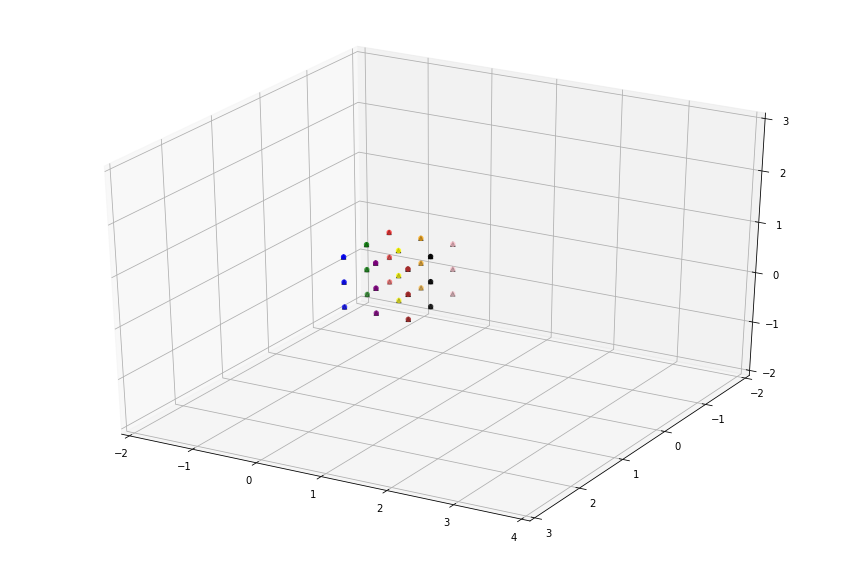

In [36]:
colors = color_list()
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], color = 'black', marker='^')
ax.scatter(rec[:, 0], rec[:, 1], rec[:, 2], c = colors)
ax.set_xlim([-2,4])
ax.set_ylim([3,-2])
ax.set_zlim([-2,3])
plt.show()

Reconstructing the points using camera 2 and camera 3 -

In [38]:
def third_camera():
    r = 5
    focal_length = 0.06
    width = 256
    height = 256
    alpha = np.pi/3
    beta = np.pi/3
    
    cam3 = { 'position': [r * np.cos(beta) * np.cos(alpha), r * np.cos(beta) * np.sin(alpha), r * np.sin(beta)],
           'target':[0,0,0],
           'up':[0,0,1],
           'focal_length':focal_length,
           'film_width':0.035,
           'film_height':0.035,
           'width':width,
           'height':height,
           }
    return cam3

In [39]:
cam3 = third_camera()

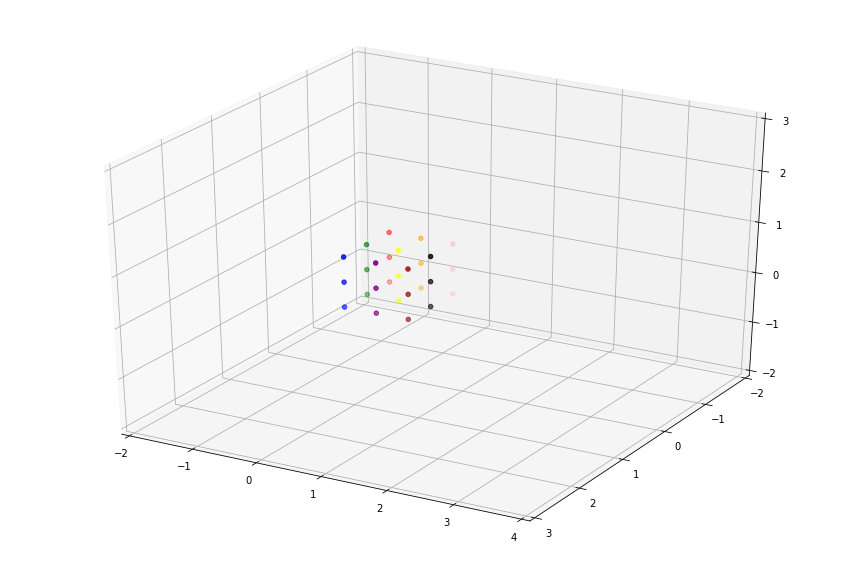

In [40]:
P3 = camera_matrix(cam3)
points2d_3, x_3, y_3 = world2image(cam3, points)
rec = triangulate(points2d_2, points2d_3, P2, P3)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(points[:, 0], points[:, 1], points[:, 2], color = 'black', marker='^')
ax.scatter(rec[:, 0], rec[:, 1], rec[:, 2], c = colors)
ax.set_xlim([-2,4])
ax.set_ylim([3,-2])
ax.set_zlim([-2,3])
plt.show()

In [62]:
# Adding noise
sigma = 1.75
shape_points = np.array(points2d_1).shape
points2d_1 = points2d_1 + sigma * np.random.rand(shape_points[0], shape_points[1])
points2d_2 = points2d_2 + sigma * np.random.rand(shape_points[0], shape_points[1])

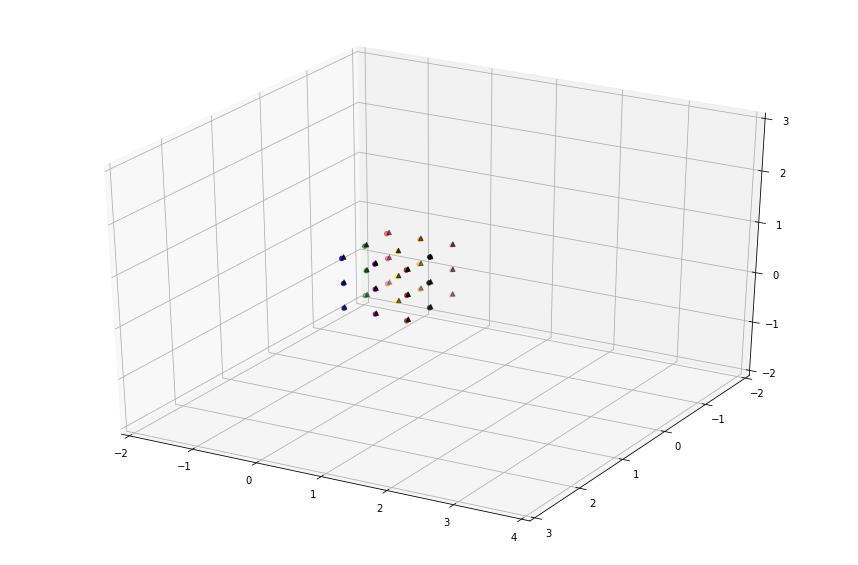

In [63]:
rec = triangulate(points2d_1, points2d_2, P1, P2)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], color = 'black', marker='^')
ax.scatter(rec[:, 0], rec[:, 1], rec[:, 2], c = colors)
ax.set_xlim([-2,4])
ax.set_ylim([3,-2])
ax.set_zlim([-2,3])
plt.show()